# The Hilbert transform

A Jupyter Notebook with source code is located at [this](https://github.com/krashkov/Blog) GitHub repository.

**Contents**

* Defenition and properties
    * Analytic signal
* Numerical example
    * Calculation of the Hilbert transform
    * Envelope
    * Frequency
* References

In [12]:
import math

import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate
import scipy.signal
import scipy.fftpack

---

## 1 Defenition and properties

**Defenition 1**. The Hilbert transform $\mathcal{H}(f)(x)$ of a function $f(x)$ is defined as:

$$
\mathcal{H}(f)(x) = p.v. \frac{1}{\pi} \int_{\mathbb{R}} \frac{f(x-t)}{t} dt
\tag{1}
$$

provided that this integral exists. Note, that (1) is in fact the convolution of $f(x)$ with the signal $\frac{1}{\pi x}$, so that the definition could be conveniently rewritten as follows:

$$
\mathcal{H}(f)(x) = \left(f*\frac{1}{\pi x}\right)(x)
$$

**Proposition 1**.

1. The Hilbert transform is linear.

$$
\mathcal{H}(\alpha f + \beta g)(x) = \alpha \mathcal{H}(f)(x) + \beta \mathcal{H}(g)(x)
$$

2. The Hilbert transform of a constant function $f(x) = c$ and Dirac delta function.

$$
\begin{aligned}
\mathcal{H}(f)(x) &= \mathcal{H}(c) = 0\\
\mathcal{H}(\delta)(x) &= \frac{1}{\pi x}
\end{aligned}
$$

3. The Hilbert transform of the derivative of a function is the derivative of the Hilbert transform.

$$
\mathcal{H}\left(\frac{df}{dx}\right)(x) = \frac{d}{dx} \mathcal{H}(f)(x)
$$

4. Relation between the Fourier transform and the Hilbert transform.

$$
\mathcal{F}\left(\mathcal{H}(f)\right)(y) = - i \text{sign}(y) \mathcal{F}(f)(y)
\tag{2}
$$

5. The Hilbert transform used twice on a real function gives the same real function with altered sign.

$$
\mathcal{H}\left(\mathcal{H}(f)\right)(x) = - f(x)
$$

**Proposition 2**. If $f \in \mathcal{L}^p(\mathbb{R}),\ p>1$, then $\exists C$:

$$
\|\mathcal{H}(f)\|_p \leq C \|f\|_p
$$

### 1.2 Analytic signal

**Defenition 2**. A complex signal $z(x)$ whose real part is $f(x)$ and imaginary part is the Hilbert transform $\hat{f}(x)$ of a real part is called the analytic signal:

$$
z(x) = f(x) + i \hat{f}(x) = A(x)e^{i\varphi(x)}
\tag{3}
$$

where $A(x)$ is an instantaneous amplitude:

$$
A(x) = \sqrt{f^2(x) + \hat{f}^2(x)}
\tag{4}
$$

and $\varphi(x) = \arctan(\hat{f}(x)/f(x))$ is an instantaneous phase. Also it is natural to introduce an instantaneous frequency as follows:

$$
\omega(x) = \frac{1}{2\pi} \frac{d \varphi(x)}{dx}
\tag{5}
$$

---

## 2 Numerical example

This example shows how to extract the envelope, information about phase and frequency of a signal using Hilbert transformation. Let us create the following amplitude-modulated signal:

$$
u(x) = A(x) \cos \Phi(x)
$$

where

$$
\begin{cases}
A(x) = e^{-x^2/b^2},\\
\Phi(x) = 2 \pi \int_0^x f (y) dy, \text{ where } f(y) = f_0 \left(1 - \alpha \cos\frac{\pi y}{a}\right)
\end{cases}
\tag{6}
$$

Let us introduce a mesh $\mathcal{T}$ on $-\frac{L}{2} \leq x \leq \frac{L}{2}$:

$$
\mathcal{T} = \left\{x_j: x_j = -\frac{L}{2} + j \frac{L}{N},\ j = 0, \cdots, N\right\}
$$

In [56]:
# Constants in Eq. 6
a     = 4
b     = 6.
alpha = 0.2
f0    = 2.

# Create mesh
L = 16.
N = 2048
x_mesh = np.linspace(-L/2, L/2, N)

Here we find and plot signal values at points defined by ```x_mesh```. 

In [59]:
def get_signal(x_mesh, a, b, alpha, f0):
    A   = np.exp(-x_mesh**2/b**2)
    Phi = 2*math.pi*f0*( x_mesh - alpha*a/math.pi*np.sin(math.pi*x_mesh/a) )
    return A*np.cos(Phi)

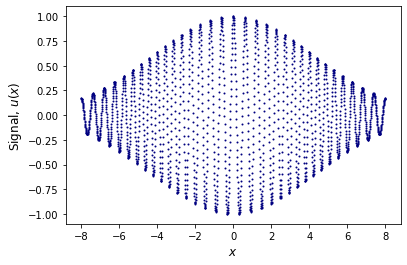

In [60]:
signal = get_signal(x_mesh, a, b, alpha, f0)

plt.figure(figsize=(6,4))
plt.scatter(x_mesh, signal, color='navy', s=1)
plt.xlabel(r"$x$",            fontsize=12)
plt.ylabel(r"Signal, $u(x)$", fontsize=12)

plt.savefig('./img/2020-03-04-hilbert-transform_1.png', bbox_inches='tight', dpi=300)
plt.show()

### 2.1 Calculation of the Hilbert transform

First thing first, we find the Fourier transform of the signal.

In [61]:
signal_fourier_tr = np.fft.fft(signal)
signal_fourier_fr = np.fft.fftfreq(n=N, d=L/N)

To find the Hilbert transform we need to rotate Fourier coefficients in the complex space and take the inverse Fourier transform according to Eq. 2.

In [62]:
def sign(x):
    if (x > 0):             return  1
    if (x < 0):             return -1
    if (np.isclose(0., x)): return  0

signal_fourier_hilbert_tr = np.zeros(shape=(signal_fourier_tr.size), dtype=complex)
for i in range(signal_fourier_tr.size):
    signal_fourier_hilbert_tr[i] = (-1)*complex(0,1)*sign(signal_fourier_fr[i])*signal_fourier_tr[i]
    
signal_hilbert_tr = np.fft.ifft(signal_fourier_hilbert_tr).real

### 2.2 Envelope

The envelope is the magnitude of the analytic signal, which is defined by Eq. 4. Let us plot the original signal along with the envelope.

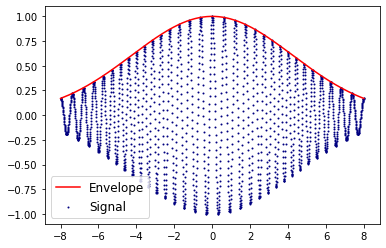

In [65]:
signal_envelope = np.sqrt(signal_hilbert_tr**2 + signal**2)

plt.plot   (x_mesh, signal_envelope, color = 'r',    label = 'Envelope')
plt.scatter(x_mesh, signal,          color = 'navy', label = 'Signal', s=1)
plt.legend (loc="best", fontsize=12)

plt.savefig('./img/2020-03-04-hilbert-transform_2.png', bbox_inches='tight', dpi=300)
plt.show()

### 2.3 Frequency



In [76]:
def get_signal_frequency(x_mesh, a, b, alpha, f0):
    return f0*( 1 - alpha*np.cos(math.pi*x_mesh/a) )

signal_frequency = get_signal_frequency(x_mesh, a, b, alpha, f0)

$$
(\sin \varphi_j)' = \cos \varphi_j \varphi_j'
$$

In [77]:
cos_phi = signal            / np.sqrt(signal_hilbert_tr**2 + signal**2)
sin_phi = signal_hilbert_tr / np.sqrt(signal_hilbert_tr**2 + signal**2)

def find_derivative(f, h):
    derivative = np.zeros(shape=(f.size))
    
    for i in range(f.size):
        if i == 0:
            derivative[i] = (f[i+1] - f[i]  ) / h
        if i == f.size-1:
            derivative[i] = (f[i]   - f[i-1]) / h
        else:
            derivative[i] = (f[i+1] - f[i-1]) / (2*h)
            
    return derivative

sin_phi_prime = find_derivative(sin_phi, L/N)
phi_prime     = sin_phi_prime / cos_phi / 2 / math.pi

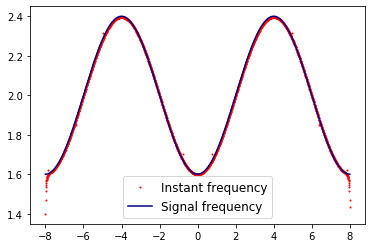

In [78]:
plt.plot(x_mesh, phi_prime,        color='red',  label='Instant frequency', marker='o', linestyle='None', ms=1)
plt.plot(x_mesh, signal_frequency, color='navy', label='Signal frequency')
plt.legend(loc="best", fontsize=12)

plt.savefig('./img/2020-03-04-hilbert-transform_2.png', bbox_inches='tight', dpi=300)
plt.show()

---

*References*

1. F. R. Kschischang. The Hilbert Transform, University of Toronto [[link](https://www.comm.utoronto.ca/frank/notes/hilbert.pdf)]